In [1]:
import pandas as pd
import requests
import gc
import time 
import warnings

from tqdm import tqdm
from pandas import json_normalize
from chicken_dinner.pubgapi import PUBG

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Request Status Check

In [2]:
api_key = "eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJqdGkiOiIwM2Y1ZmRlMC0xNjBlLTAxM2ItNTZmNy0xZGFlNDU1OWZhNzAiLCJpc" \
          "3MiOiJnYW1lbG9ja2VyIiwiaWF0IjoxNjYzMTI3MzA3LCJwdWIiOiJibHVlaG9sZSIsInRpdGxlIjoicHViZyIsImFwcCI6Ii01NjR" \
          "hMTczOC02YWE0LTQyZDktODcwNC0xMzUzNGFiOGIyNjUifQ.GRoBYwy9oOB07_OORC16f_f4m_mzEEM0BwQ9Qh2gNHU"

accept = 'application/vnd.api+json'

In [3]:
url = 'https://api.pubg.com/shards/kakao/samples?filter[createdAt-start]=2022-09-11T00%3A00%3A00Z'
header = {
    'Authorization' : api_key,
    'Accept' : accept
}

request = requests.get(url, headers = header)
print(request)

<Response [400]>


## Match Id

In [5]:
# maximum is 2 weeks (13 days)

def get_match_id(start_date, end_date):
    json_lst = []
    i = 1
    for day in tqdm(range(start_date, end_date + 1)):
        if day < 10:
            url = f'https://api.pubg.com/shards/kakao/samples?filter[createdAt-start]=2022-09-0{day}T00%3A00%3A00Z'
        else:
            url = f'https://api.pubg.com/shards/kakao/samples?filter[createdAt-start]=2022-09-{day}T00%3A00%3A00Z'
        request = requests.get(url, headers = header)
        
        if request.status_code == 400:
            print(f"day {day} is not updated or outdated")
            return json_lst
        
        json_lst.append(request.json())
        print(f"day {day} done")
        if i % 10 == 0:
            print("waiting to refresh rate limit")
            time.sleep(60)
        i += 1
        print("status code: ", request.status_code)
    return json_lst
    

In [6]:
json_lst = get_match_id(27, 27)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

day 27 done
status code:  200


### get match_id

In [7]:
def get_match_id_df(match_json_lst):
    match_id_df = pd.DataFrame()
    for i in range(len(match_json_lst)):
        temp = pd.DataFrame(match_json_lst[i]["data"]["relationships"]["matches"]["data"])
        match_id_df = pd.concat([match_id_df, temp], axis= 0)
    return match_id_df.reset_index(drop = True)


In [8]:
match_id_df = get_match_id_df(json_lst)
match_id_df = pd.concat([pd.read_csv("match_id_df.csv"),match_id_df], axis = 0).reset_index(drop = True)
match_id_df.to_csv("match_id_df.csv", index = False)
match_id_df = get_match_id_df(json_lst)
match_id_df

,type,id
0,match,a590e40a-1d1b-4b6a-b13d-04212345c65a
1,match,79cae82c-e045-4a1a-a378-bb96b225b885
2,match,a7621a43-b813-44ac-aab8-184e9d9a4be2
3,match,6d93927d-19d9-4c8b-aeb5-cfcd95488e86
4,match,d95df6f6-1fbf-4a21-98a4-e4914e164965
...,...,...
213,match,f15ef8e8-a721-41fa-b67a-60759fbbe6b9
214,match,0292d8a0-bce2-4b40-9138-c26ef4bdf3d7
215,match,ac87912a-5d19-4f71-88bd-438399ee2387
216,match,19714d3c-7733-437f-8b00-4dbed6a422c6


In [9]:
url = "https://api.pubg.com/shards/kakao/matches/23c15aa7-d87d-494d-b926-9796940baed9"
header = {
    'Authorization' : api_key,
    'Accept' : accept
}
request = requests.get(url, headers = header)

In [10]:
match_data = pd.DataFrame()
for m_id in tqdm((match_id_df["id"])):
    url = f"https://api.pubg.com/shards/kakao/matches/{m_id}"
    request = requests.get(url, headers = header)
    if request.status_code == 200:
        match_data = pd.concat([match_data,json_normalize(request.json())], axis = 0)
    elif request.status_code == 404:
        print("The specified resource was not found")
match_json = match_data.loc[match_data["data.attributes.matchType"] == "competitive",:].reset_index(drop = True)
match_json[:2]

100%|█████████████████████████████████████████| 218/218 [01:36<00:00,  2.27it/s]


,included,data.type,data.id,data.attributes.createdAt,data.attributes.shardId,data.attributes.tags,data.attributes.mapName,data.attributes.isCustomMatch,data.attributes.duration,data.attributes.stats,data.attributes.gameMode,data.attributes.titleId,data.attributes.matchType,data.attributes.seasonState,data.relationships.assets.data,data.relationships.rosters.data,data.links.schema,data.links.self,links.self
0,"[{'type': 'participant', 'id': 'b0d85fbe-f44f-...",match,079b9626-0e73-489b-9001-91044247dd08,2022-09-27T03:06:50Z,kakao,None,Desert_Main,False,1798,None,squad,bluehole-pubg,competitive,progress,"[{'type': 'asset', 'id': 'e1d4eb7b-3e15-11ed-9...","[{'type': 'roster', 'id': '2ce608cc-83a1-4327-...",,https://api.pubg.com/shards/kakao/matches/079b...,https://api-origin.playbattlegrounds.com/shard...
1,"[{'type': 'participant', 'id': '477262d3-1126-...",match,33eceeba-4a2e-403b-83e0-1223080b6775,2022-09-27T03:14:38Z,kakao,None,Tiger_Main,False,1780,None,squad,bluehole-pubg,competitive,progress,"[{'type': 'asset', 'id': 'edcafa93-3e16-11ed-a...","[{'type': 'roster', 'id': '29c0fc29-0b94-4dfa-...",,https://api.pubg.com/shards/kakao/matches/33ec...,https://api-origin.playbattlegrounds.com/shard...


In [11]:
# match_json.to_json("match_data.json")
match_json.to_json("match_data_27.json")

### Split to Roster_df & Participant_df

In [12]:
# pip install chicken_dinner

In [13]:
%%time

pubg = PUBG(api_key, shard = "kakao")

participant_dict = {}
roster_dict = {}
participant_df = pd.DataFrame()

for match in tqdm(range(len(match_json))):
    
    # get roster_id
    match_id = match_json.iloc[match, ]['data.id']
    # match_id = '4a9e8350-c38b-4552-ba24-ef3311912fdc'
    current_match = pubg.match(match_id)
    roster_dict.update(current_match.participant_to_roster)
    
    # get participant_id
    for included in match_json.iloc[match, ]['included']:
        if included['type'] == 'participant':

            participants = pd.json_normalize(included['attributes']['stats'])
            participants['participant_id'] = included['id']
            participant_df = pd.concat([participant_df, participants], axis = 0, ignore_index = True)

participant_df = participant_df[['participant_id', 'DBNOs', 'assists', 'boosts', 'damageDealt', 'deathType',
                                 'headshotKills', 'heals', 'killPlace', 'killStreaks', 'kills',
                                 'longestKill', 'name', 'playerId', 'revives', 'rideDistance',
                                 'roadKills', 'swimDistance', 'teamKills', 'timeSurvived',
                                 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPlace']]

# roster_df = pd.DataFrame({'participant_id' : roster_dict.keys(), 'roster_id' : roster_dict.values()})
# participant_df = pd.merge(participant_df, roster_df)
participant_df

100%|███████████████████████████████████████████| 47/47 [00:02<00:00, 16.68it/s]

CPU times: user 2.11 s, sys: 36 ms, total: 2.14 s
Wall time: 2.82 s


,participant_id,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,kills,longestKill,name,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,b0d85fbe-f44f-45cf-a297-00e24ed21c1e,2,2,3,287.676730,byplayer,0,1,20,1,1,41.63401,14K-Jalhae,account.279199103dc547f89683a59632b47110,0,6559.7600,0,0.0,0,1109,0,1658.52940,5,10
1,18022219-5e38-4fbd-a7e2-4dcb6b01549a,0,0,0,53.060320,byplayer,0,0,57,0,0,0.00000,sexy-kdh,account.35a0b81dcc444561ab65c310898f3dc7,0,0.0000,0,0.0,0,213,0,240.23311,4,15
2,506631a3-71ef-4450-af80-d2a2969fb149,0,0,1,18.449999,byplayer,0,0,30,0,0,0.00000,AXIS_MOON2,account.f5e2d7016ec842a7821a90bc03708ec1,0,1938.5726,0,0.0,0,507,0,702.10490,4,3
3,5952413c-9548-45da-845b-4c8864f23216,0,0,5,425.887900,byplayer,0,6,33,0,0,0.00000,14K-fightingsoo,account.14e3c139bc6b479abb331a89e9909980,0,4144.7400,0,0.0,0,1531,0,1395.89940,5,5
4,ca7946cd-16a0-49f4-9131-078d3de57ef0,0,0,5,60.277714,byplayer,0,3,49,0,0,0.00000,S0-H0T,account.abfc382406a044199ff3b06d92dfc224,0,3269.2507,0,0.0,0,744,0,828.21234,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,2fa1349d-5f10-4dab-8268-f96dfae5040b,1,1,10,449.390230,alive,0,6,9,1,2,83.17705,blackdragon12345,account.b8c84afae55f4251a81d0bc60f7c67f7,0,6331.7305,0,0.0,0,1810,0,3325.77540,4,1
2877,8076f279-81ec-4794-b8fa-5ea793a00651,1,0,5,411.608520,byplayer,0,2,44,0,0,0.00000,This_Is_KOR,account.f045cdfe4ce14119a7a1d72af6edf3d3,0,0.0000,0,0.0,0,1119,0,2030.63500,7,12
2878,44d3b106-45ea-49de-8bcc-ee77279f9da7,0,1,7,18.810000,byplayer,0,1,35,0,0,0.00000,DDOHAo_ov,account.02e98b4eb4674aaea3c62536cd607084,0,6141.2007,0,0.0,0,1480,0,2468.64650,5,4
2879,d021d03b-f8d8-4f6a-a55a-31ce09018ca5,2,0,1,136.643020,byplayer,1,0,13,1,2,23.25779,18K-TheHaGi,account.207725b74cec4d77919295d2cb05453f,0,0.0000,0,0.0,0,268,0,277.62695,3,16


### Number of unique players

In [14]:
print("Number of players in total: ", participant_df.shape[0])
print("Number of unique players: ", participant_df["playerId"].nunique())

Number of players in total:  2881
Number of unique players:  2594


## SeasonId

### Current Season of Pubg(Kakao)

In [15]:
url = "https://api.pubg.com/shards/kakao/seasons"
request = requests.get(url, headers = header)
request.json()["data"]
season_id = [d['id'] for d in request.json()["data"] if ("pc" in d["id"]) & d["attributes"]["isCurrentSeason"] == True][0]
account_id_lst = participant_df["playerId"].drop_duplicates(keep = "last").reset_index(drop = True).to_list()

print("number of accounts (unique players) : ",len(account_id_lst))
print("current season: ", season_id)

number of accounts (unique players) :  2594
current season:  division.bro.official.pc-2018-19


### ranked_df should be needed

In [305]:
# ranked_df = pd.read_csv("ranked_df.csv")
# print(len(account_id_lst))
# account_id_lst = [account for account in account_id_lst if account not in ranked_df["player_data_id"].to_list()]
# print(len(account_id_lst))

902
902


## Rankedplayer Table

In [ ]:
%%time
ranked_df = pd.DataFrame()
for account_id in tqdm(account_id_lst):
    
    url = f"https://api.pubg.com/shards/kakao/players/{account_id}/seasons/{season_id}/ranked"

    try:        
        request = requests.get(url, headers = header)
    except JSONDecodeError:
        print("JSONDecodeError occured")
        time.sleep(60)
        request = requests.get(url, headers = header)
        
    if request.status_code == 429:
        time.sleep(60)
        request = requests.get(url, headers = header)
    ranked_df = pd.concat([ranked_df, json_normalize(request.json()["data"])], axis = 0, ignore_index = True)
    


 52%|███████████████████▍                 | 1359/2594 [2:31:01<26:00,  1.26s/it]

In [309]:
ranked_df

,type,attributes.rankedGameModeStats.squad.currentTier.tier,attributes.rankedGameModeStats.squad.currentTier.subTier,attributes.rankedGameModeStats.squad.currentRankPoint,attributes.rankedGameModeStats.squad.bestTier.tier,attributes.rankedGameModeStats.squad.bestTier.subTier,attributes.rankedGameModeStats.squad.bestRankPoint,attributes.rankedGameModeStats.squad.roundsPlayed,attributes.rankedGameModeStats.squad.avgRank,attributes.rankedGameModeStats.squad.avgSurvivalTime,attributes.rankedGameModeStats.squad.top10Ratio,attributes.rankedGameModeStats.squad.winRatio,attributes.rankedGameModeStats.squad.assists,attributes.rankedGameModeStats.squad.wins,attributes.rankedGameModeStats.squad.kda,attributes.rankedGameModeStats.squad.kdr,attributes.rankedGameModeStats.squad.kills,attributes.rankedGameModeStats.squad.deaths,attributes.rankedGameModeStats.squad.roundMostKills,attributes.rankedGameModeStats.squad.longestKill,attributes.rankedGameModeStats.squad.headshotKills,attributes.rankedGameModeStats.squad.headshotKillRatio,attributes.rankedGameModeStats.squad.damageDealt,attributes.rankedGameModeStats.squad.dBNOs,attributes.rankedGameModeStats.squad.reviveRatio,attributes.rankedGameModeStats.squad.revives,attributes.rankedGameModeStats.squad.heals,attributes.rankedGameModeStats.squad.boosts,attributes.rankedGameModeStats.squad.weaponsAcquired,attributes.rankedGameModeStats.squad.teamKills,attributes.rankedGameModeStats.squad.playTime,attributes.rankedGameModeStats.squad.killStreak,relationships.player.data.type,relationships.player.data.id,relationships.season.data.type,relationships.season.data.id
0,rankedplayerstats,Platinum,2,2881.0,Diamond,5,3088.0,435.0,8.960919,0.0,0.604598,0.055172,197.0,24.0,2.097156,0.0,688.0,422.0,0.0,0.0,0.0,0.0,125494.8300,710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.81a1dcbc93f849468d0d67f865c93a95,season,division.bro.official.pc-2018-19
1,rankedplayerstats,Bronze,1,1422.0,Silver,4,1614.0,55.0,10.690909,0.0,0.381818,0.036364,12.0,2.0,0.641509,0.0,22.0,53.0,0.0,0.0,0.0,0.0,6320.2188,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.e1a8556098aa494eb85eddd7c9751463,season,division.bro.official.pc-2018-19
2,rankedplayerstats,Silver,1,1985.0,Gold,2,2320.0,476.0,9.464286,0.0,0.560924,0.014706,109.0,7.0,0.626327,0.0,186.0,471.0,0.0,0.0,0.0,0.0,49672.6050,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.607af11b85c842379b96904f846d9fae,season,division.bro.official.pc-2018-19
3,rankedplayerstats,Gold,4,2153.0,Gold,3,2260.0,565.0,9.686726,0.0,0.529204,0.044248,99.0,25.0,0.441392,0.0,142.0,546.0,0.0,0.0,0.0,0.0,36358.7900,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.7c36dd54b3384da88e7adec7af5f13f0,season,division.bro.official.pc-2018-19
4,rankedplayerstats,Gold,3,2289.0,Platinum,5,2510.0,196.0,10.035714,0.0,0.500000,0.025510,120.0,5.0,1.727749,0.0,210.0,191.0,0.0,0.0,0.0,0.0,38841.7070,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.933ec0f253ad45fbbb75bb3470ac22bb,season,division.bro.official.pc-2018-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,rankedplayerstats,Diamond,4,3127.0,Diamond,1,3422.0,488.0,6.760246,0.0,0.754098,0.133197,374.0,65.0,1.819222,0.0,421.0,437.0,0.0,0.0,0.0,0.0,87127.1700,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.a97a170846af44d1805ccd9d2d06cc63,season,division.bro.official.pc-2018-19
898,rankedplayerstats,Diamond,3,3207.0,Diamond,2,3313.0,447.0,8.389262,0.0,0.601790,0.091723,326.0,41.0,2.694915,0.0,787.0,413.0,0.0,0.0,0.0,0.0,162278.6200,871.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.5db7cc00e64c4e11aea019faca1ac905,season,division.bro.official.pc-2018-19
899,rankedplayerstats,Diamond,5,3002.0,Diamond,1,3445.0,111.0,6.351351,0.0,0.738739,0.261261,186.0,29.0,4.347826,0.0,214.0,92.0,0.0,0.0,0.0,0.0,38994.1330,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.2721346010ee4425820ec0f411f347c7,season,division.bro.official.pc-2018-19
900,ran

In [310]:
print(ranked_df.shape)
ranked_df = ranked_df.loc[ranked_df["relationships.player.data.id"].drop_duplicates().index,:]
ranked_df = ranked_df.reset_index(drop = True)
print(ranked_df.shape)

(902, 36)
(902, 36)


### reset column names

In [172]:
def get_column_name(df):
    column_lst = []
    for col in df.columns:
        if col.split(".")[0] == "attributes":
            if (col.split(".")[-1] == "tier") | (col.split(".")[-1] == "subTier") :
                column_lst.append("_".join(col.split(".")[-2:]))
            else: column_lst.append(col.split(".")[-1])
        elif col.split(".")[0] == "relationships":
            column_lst.append("_".join(np.array(col.split("."))[[1,3]]))
        else: column_lst.append(col)
    return column_lst

In [311]:
ranked_df.columns = get_column_name(ranked_df)
ranked_df.head()

,type,currentTier_tier,currentTier_subTier,currentRankPoint,bestTier_tier,bestTier_subTier,bestRankPoint,roundsPlayed,avgRank,avgSurvivalTime,top10Ratio,winRatio,assists,wins,kda,kdr,kills,deaths,roundMostKills,longestKill,headshotKills,headshotKillRatio,damageDealt,dBNOs,reviveRatio,revives,heals,boosts,weaponsAcquired,teamKills,playTime,killStreak,player_type,player_id,season_type,season_id
0,rankedplayerstats,Platinum,2,2881.0,Diamond,5,3088.0,435.0,8.960919,0.0,0.604598,0.055172,197.0,24.0,2.097156,0.0,688.0,422.0,0.0,0.0,0.0,0.0,125494.8300,710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.81a1dcbc93f849468d0d67f865c93a95,season,division.bro.official.pc-2018-19
1,rankedplayerstats,Bronze,1,1422.0,Silver,4,1614.0,55.0,10.690909,0.0,0.381818,0.036364,12.0,2.0,0.641509,0.0,22.0,53.0,0.0,0.0,0.0,0.0,6320.2188,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.e1a8556098aa494eb85eddd7c9751463,season,division.bro.official.pc-2018-19
2,rankedplayerstats,Silver,1,1985.0,Gold,2,2320.0,476.0,9.464286,0.0,0.560924,0.014706,109.0,7.0,0.626327,0.0,186.0,471.0,0.0,0.0,0.0,0.0,49672.6050,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.607af11b85c842379b96904f846d9fae,season,division.bro.official.pc-2018-19
3,rankedplayerstats,Gold,4,2153.0,Gold,3,2260.0,565.0,9.686726,0.0,0.529204,0.044248,99.0,25.0,0.441392,0.0,142.0,546.0,0.0,0.0,0.0,0.0,36358.7900,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.7c36dd54b3384da88e7adec7af5f13f0,season,division.bro.official.pc-2018-19
4,rankedplayerstats,Gold,3,2289.0,Platinum,5,2510.0,196.0,10.035714,0.0,0.500000,0.025510,120.0,5.0,1.727749,0.0,210.0,191.0,0.0,0.0,0.0,0.0,38841.7070,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,player,account.933ec0f253ad45fbbb75bb3470ac22bb,season,division.bro.official.pc-2018-19


In [323]:
ranked_df_26.to_csv("ranked_df_26.csv", index = False)
# ranked_df_26 = ranked_df

In [99]:
# ranked_df_25 = pd.concat([ranked_df, pd.read_csv("ranked_df_sep25.csv")], axis= 0).reset_index(drop = True)
# ranked_df_25.to_csv("ranked_df_25.csv", index = False)

In [337]:
ranked_df = pd.read_csv("ranked_df.csv")
print(ranked_df.shape)
ranked_df = pd.concat([ranked_df, ranked_df_26], axis = 0, ignore_index = True)
print(ranked_df.shape)
ranked_df = ranked_df.iloc[ranked_df["player_id"].drop_duplicates(keep = "last").index,:].reset_index(drop = True)
print(ranked_df.shape)

(37654, 36)
(38556, 36)
(38043, 36)


### Drop columns

In [338]:
def drop_columns(df):
    drop_col_lst = []
    for col in df.columns[:-1]:
        if len(df[col].value_counts()) == 1:
            drop_col_lst.append(col)
    return df.drop(drop_col_lst, axis = 1)



def change_type(df):
    df = df.dropna(axis = 0)
    num_columns = rank_stats_df.select_dtypes(exclude = "object").columns.to_list()
    int_columns = list(set(num_columns) - set(["avgRank", "top10Ratio", "winRatio", "kda", "damageDealt"]))
    df[int_columns] = df[int_columns].astype(int)
    return df


In [339]:
ranked_df = drop_columns(ranked_df)
rank_stats_df = change_type(ranked_df)
rank_stats_df

,currentTier_tier,currentTier_subTier,currentRankPoint,bestTier_tier,bestTier_subTier,bestRankPoint,roundsPlayed,avgRank,top10Ratio,winRatio,assists,wins,kda,kills,deaths,damageDealt,dBNOs,player_id,season_id
0,Silver,4,1687,Silver,1,1921,65,10.892307,0.461538,0.061538,18,4,1.083333,47,60,8589.5660,43,account.6394bd8602da4beaaba53455e0d7cb48,division.bro.official.pc-2018-19
1,Silver,1,1981,Gold,4,2136,142,10.091549,0.478873,0.028169,52,4,1.130435,104,138,24746.3600,134,account.79dbea3461384834bdf3f95c67bf78c1,division.bro.official.pc-2018-19
2,Diamond,4,3183,Diamond,3,3221,87,6.080460,0.781609,0.195402,90,17,3.608108,177,74,40527.1800,168,account.70ba22c3c1cc4d6481f7b4db7cd77bda,division.bro.official.pc-2018-19
3,Platinum,1,2912,Diamond,5,3080,224,8.415178,0.620536,0.098214,151,22,2.354369,334,206,77854.7300,370,account.35a4eb4b796d463390cdba1ae37e89b5,division.bro.official.pc-2018-19
4,Diamond,4,3128,Diamond,2,3318,200,8.240000,0.620000,0.105000,209,21,3.502732,432,183,94867.3600,440,account.acc6129f46a449698d755b300ff7cafa,division.bro.official.pc-2018-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38038,Diamond,4,3127,Diamond,1,3422,488,6.760246,0.754098,0.133197,374,65,1.819222,421,437,87127.1700,404,account.a97a170846af44d1805ccd9d2d06cc63,division.bro.official.pc-2018-19
38039,Diamond,3,3207,Diamond,2,3313,447,8.389262,0.601790,0.091723,326,41,2.694915,787,413,162278.6200,871,account.5db7cc00e64c4e11aea019faca1ac905,division.bro.official.pc-2018-19
38040,Diamond,5,3002,Diamond,1,3445,111,6.351351,0.738739,0.261261,186,29,4.347826,214,92,38994.1330,194,account.2721346010ee4425820ec0f411f347c7,division.bro.official.pc-2018-19
38041,Gold,5,2006,Gold,4,2191,39,9.538462,0.461538,0.051282,16,2,1.277778,30,36,8001.5103,36,account.ba52057ea9ee4152b93e8c2c783f1d25,division.bro.official.pc-2018-19


In [340]:
rank_stats_df.to_csv("rank_stats_df.csv", index = False)

---

# Insert into databse

In [ ]:
# !pip install pymysql
# !pip install sqlalchemy

In [344]:
import pandas as pd
import pymysql

from sqlalchemy import create_engine

### local
# host = "localhost"
# user = "root"
# password = "mysql"
# db = "pubg"
# charset = "utf8"

### gcp
host = "34.64.247.176"
user = "root"
password = "mupubg"
db = "pubg"
charset = "utf8"

rank_stats_df = pd.read_csv("rank_stats_df.csv")
match_id_df = pd.read_csv("match_id_df.csv")

In [345]:
engine = create_engine(f"mysql+pymysql://{user}:" + password + f"@{host}:3306/{db}", encoding = "utf-8")
engine_conn = engine.connect()

# rankrank_stats_df_df
rank_stats_df.to_sql(name = "rank_stats", con = engine_conn, if_exists = "replace", index = False)

# match_id
match_id_df.to_sql(name = "match_id", con = engine_conn, if_exists = "replace", index = False)

# sqlalchemy close
engine_conn.close()


In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='best_tier', ylabel='count'>

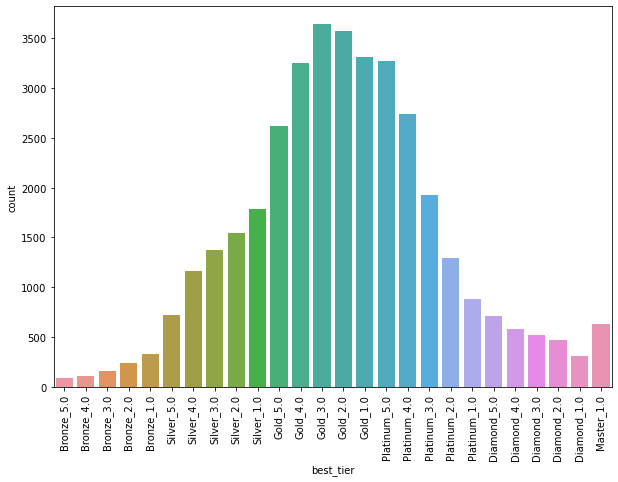

In [297]:
plt.figure(figsize = (10,7))
plt.xticks(rotation=90)
sns.countplot(data = rank_stats_df.sort_values("bestRankPoint"), x = "best_tier")

## master tier is not fractionized. thus, the count is larger than other individuals

In [346]:
rank_stats_df

,currentTier_tier,currentTier_subTier,currentRankPoint,bestTier_tier,bestTier_subTier,bestRankPoint,roundsPlayed,avgRank,top10Ratio,winRatio,assists,wins,kda,kills,deaths,damageDealt,dBNOs,player_id,season_id
0,Silver,4,1687,Silver,1,1921,65,10.892307,0.461538,0.061538,18,4,1.083333,47,60,8589.5660,43,account.6394bd8602da4beaaba53455e0d7cb48,division.bro.official.pc-2018-19
1,Silver,1,1981,Gold,4,2136,142,10.091549,0.478873,0.028169,52,4,1.130435,104,138,24746.3600,134,account.79dbea3461384834bdf3f95c67bf78c1,division.bro.official.pc-2018-19
2,Diamond,4,3183,Diamond,3,3221,87,6.080460,0.781609,0.195402,90,17,3.608108,177,74,40527.1800,168,account.70ba22c3c1cc4d6481f7b4db7cd77bda,division.bro.official.pc-2018-19
3,Platinum,1,2912,Diamond,5,3080,224,8.415178,0.620536,0.098214,151,22,2.354369,334,206,77854.7300,370,account.35a4eb4b796d463390cdba1ae37e89b5,division.bro.official.pc-2018-19
4,Diamond,4,3128,Diamond,2,3318,200,8.240000,0.620000,0.105000,209,21,3.502732,432,183,94867.3600,440,account.acc6129f46a449698d755b300ff7cafa,division.bro.official.pc-2018-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37642,Diamond,4,3127,Diamond,1,3422,488,6.760246,0.754098,0.133197,374,65,1.819222,421,437,87127.1700,404,account.a97a170846af44d1805ccd9d2d06cc63,division.bro.official.pc-2018-19
37643,Diamond,3,3207,Diamond,2,3313,447,8.389262,0.601790,0.091723,326,41,2.694915,787,413,162278.6200,871,account.5db7cc00e64c4e11aea019faca1ac905,division.bro.official.pc-2018-19
37644,Diamond,5,3002,Diamond,1,3445,111,6.351351,0.738739,0.261261,186,29,4.347826,214,92,38994.1330,194,account.2721346010ee4425820ec0f411f347c7,division.bro.official.pc-2018-19
37645,Gold,5,2006,Gold,4,2191,39,9.538462,0.461538,0.051282,16,2,1.277778,30,36,8001.5103,36,account.ba52057ea9ee4152b93e8c2c783f1d25,division.bro.official.pc-2018-19


<AxesSubplot:xlabel='bestRankPoint', ylabel='top10Ratio'>

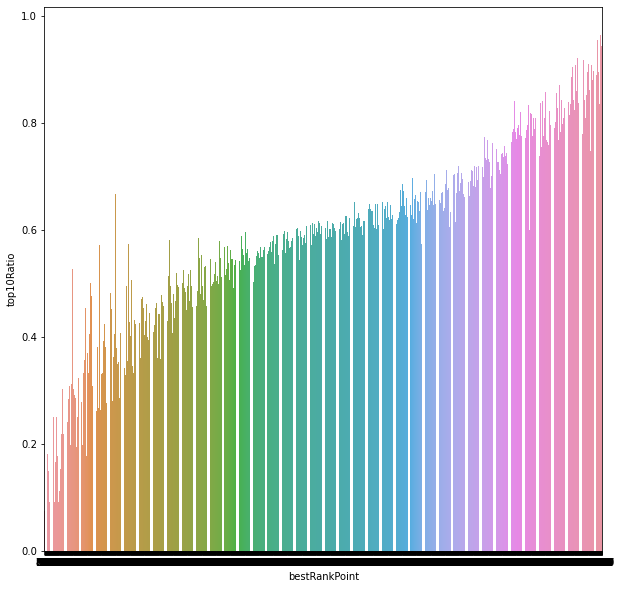

In [349]:
plt.figure(figsize = (10,10))
sns.barplot(data = rank_stats_df.sort_values("bestRankPoint"), x = "bestRankPoint", y = "top10Ratio", ci= None)